In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms
import torchvision
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

def imshow(img, ax=None):
    npimg = img.detach().numpy()
    npimg = npimg / 2 + 0.5  # обратное афинное преобразование
    if ax is None:
        if npimg.shape[0] == 1:  # 1 channel
            plt.imshow(np.squeeze(npimg))
        else:  # 3 channels
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
    else:
        if npimg.shape[0] == 1:  # 1 channel
            ax.imshow(np.squeeze(npimg))
        else:  # 3 channels
            ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
from generators import SimpleImageGenerator

In [5]:
noise_dimension = 10
def uniform_noise_generator(n: int) -> torch.Tensor:
    return torch.rand(size=(n, noise_dimension))

In [6]:
generator = SimpleImageGenerator(noise_dim=noise_dimension, output_shape=(1, 32, 32))

In [7]:
generator(uniform_noise_generator(1))[0].shape

torch.Size([1, 32, 32])

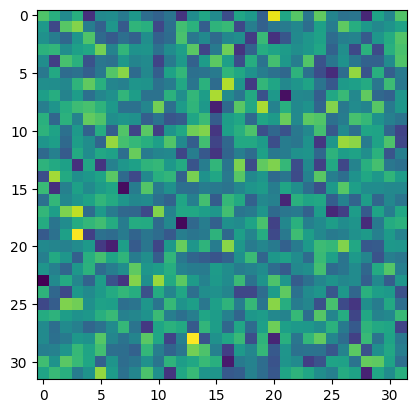

In [8]:
imshow(generator(uniform_noise_generator(1))[0])

In [9]:
from discriminators import SimpleImageDiscriminator

In [10]:
discr = SimpleImageDiscriminator()

In [11]:
discr(generator(uniform_noise_generator(1)))

tensor([[0.3947]], grad_fn=<AddmmBackward0>)

## Обучение GAN на MNIST

In [4]:
from device import get_local_device

In [5]:
from gan import GAN

In [19]:
def gen_several_images(gan_model: GAN, n: int = 5, y=None, figsize=(13, 13), transform=None):
    """
    Выводит n изображений, сгенерированных gan_model в строке
    """
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=figsize)
    gan_model.to(get_local_device())
    with torch.no_grad():
        noise_batch = gan_model.gen_noise(n).to(get_local_device())
        gen_batch = gan_model.generator(noise_batch, y)
        
    if n == 1:
        axs = [axs]
    for i, (tensor, ax) in enumerate(zip(gen_batch, axs)):
        if transform is not None:
            tensor = transform(tensor)
        imshow(tensor.cpu(), ax=ax)
        if y is not None and isinstance(y, torch.Tensor):
            ax.set_xlabel(y[i].item())
        
    plt.show()

In [14]:
from data import get_mnist_dataset, default_image_transform

In [15]:
mnist_dataset = get_mnist_dataset()

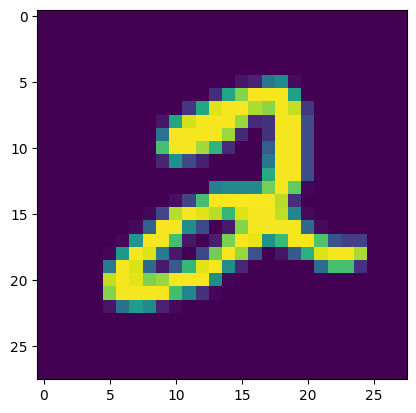

In [16]:
imshow(mnist_dataset[5][0])

In [12]:
from main import form_gan_trainer

In [ ]:
gan_trainer = form_gan_trainer(model_name='mnist_test', n_epochs=4000)

epochs done: 200


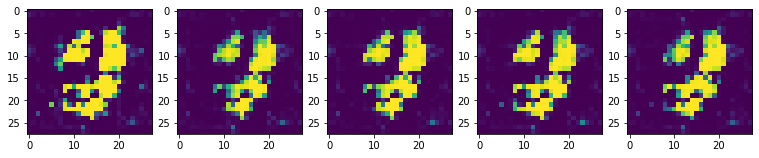

epochs done: 400


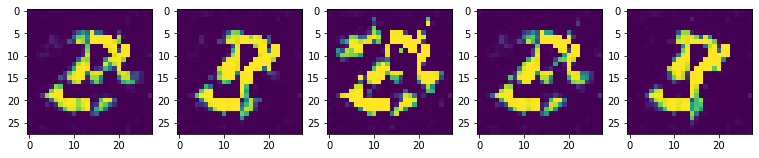

epochs done: 600


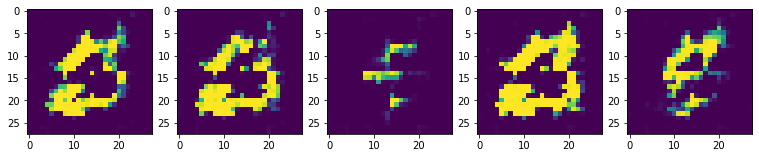

epochs done: 800


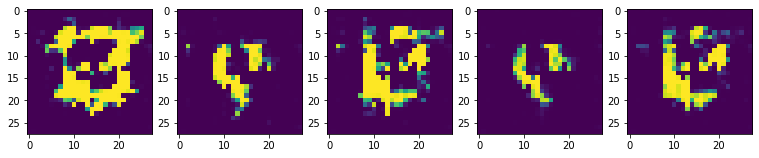

epochs done: 1000


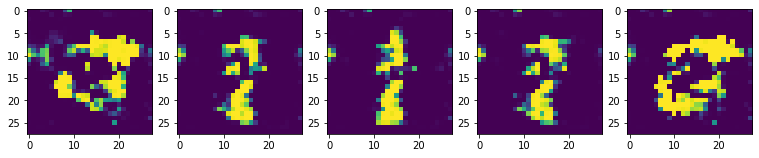

epochs done: 1200


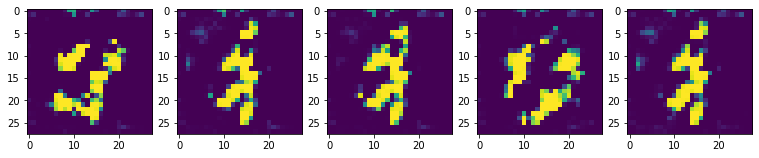

epochs done: 1400


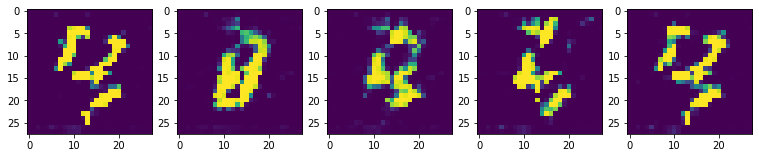

epochs done: 1600


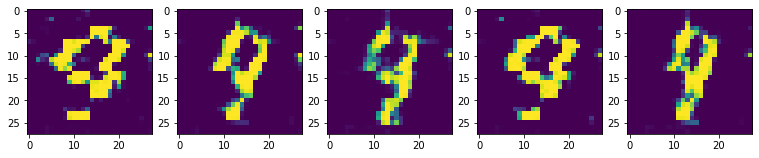

epochs done: 1800


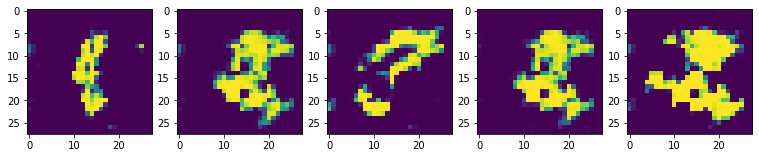

epochs done: 2000


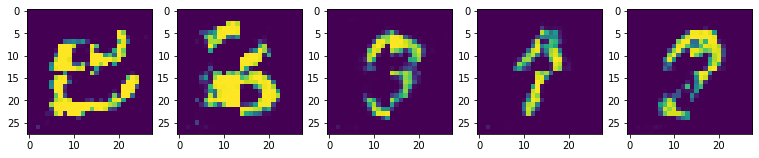

epochs done: 2200


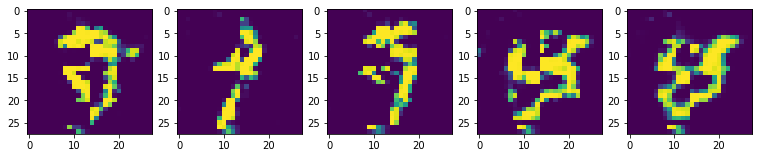

epochs done: 2400


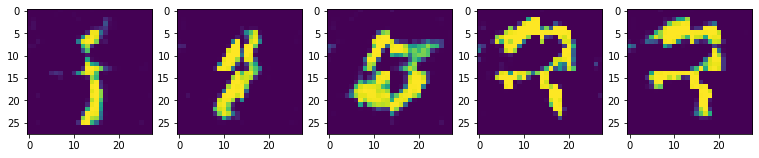

epochs done: 2600


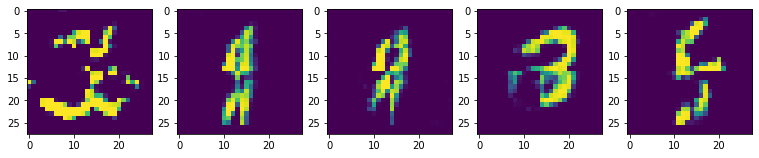

epochs done: 2800


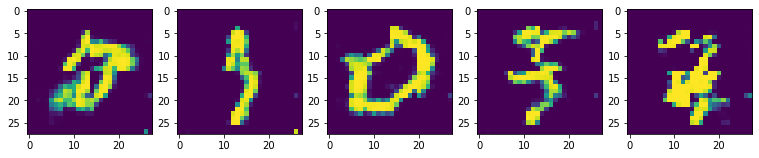

epochs done: 3000


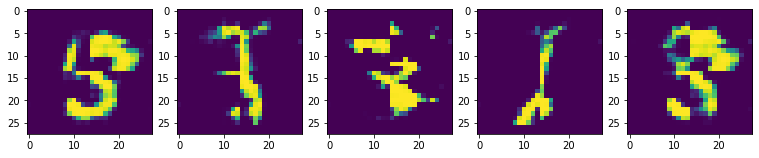

epochs done: 3200


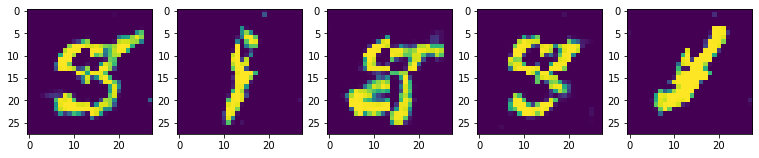

epochs done: 3400


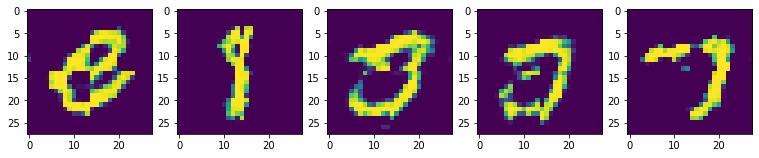

epochs done: 3600


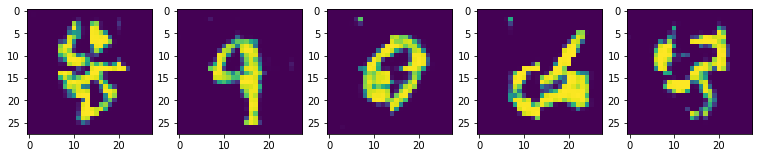

epochs done: 3800


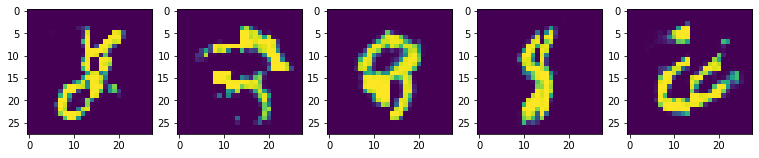

epochs done: 4000


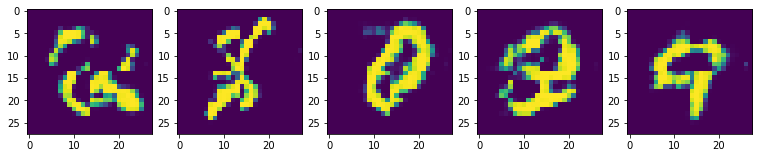

In [ ]:
for epoch, gan in gan_trainer:
    if epoch % 200 == 0:
        print(f'epochs done: {epoch}')
        gen_several_images(gan, 5)

## Conditional GAN

Со spectral normalization

In [12]:
import contextlib
import os
from enum import Enum, auto
from typing import Tuple, Generator, Optional

import torch

import data
from discriminators import SimpleImageDiscriminator, MNISTDiscriminator
from gan import GAN
from generators import SimpleImageGenerator, MNISTGenerator
from logger import Logger, StreamHandler, WandbHandlerCM
from normalization import apply_normalization, ClippingNormalizer, SpectralNormalizer
from storage import ExperimentsStorage
from train import Stepper, WganEpochTrainer, GanTrainer

In [13]:
from main import experiments_storage, init_logger

In [16]:
def form_mnist_gan_trainer(model_name: str, gan_model: Optional[GAN] = None, n_epochs: int = 100) -> Generator[Tuple[int, GAN], None, GAN]:
    """
    :return: a generator that yields (epoch number, gan_model after this epoch)
    """
#     classes_cnt = 10
    classes_cnt = 0

    logger_cm_fn = init_logger(model_name)
    dataset = data.get_mnist_dataset(keep_labels=False)

    noise_dimension = 50

    def uniform_noise_generator(n: int) -> torch.Tensor:
        return 2*torch.rand(size=(n, noise_dimension)) - 1  # [-1, 1]

    generator = MNISTGenerator(noise_dim=noise_dimension, condition_classes_cnt=classes_cnt)
    discriminator = MNISTDiscriminator(condition_classes_cnt=classes_cnt)
    discriminator = apply_normalization(discriminator, SpectralNormalizer)
    
    if gan_model is None:
        gan_model = GAN(generator, discriminator, uniform_noise_generator)

    generator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(generator.parameters(), lr=1e-3)
    )

    discriminator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(discriminator.parameters(), lr=1e-5)
    )

    epoch_trainer = WganEpochTrainer(n_critic=5, batch_size=64)

    model_dir = experiments_storage.get_model_dir(model_name)
    trainer = GanTrainer(model_dir=model_dir, use_saved_checkpoint=True, save_checkpoint_once_in_epoch=10000)
    train_gan_generator = trainer.train(dataset=dataset, gan_model=gan_model,
                                        generator_stepper=generator_stepper,
                                        critic_stepper=discriminator_stepper,
                                        epoch_trainer=epoch_trainer,
                                        n_epochs=n_epochs,
                                        logger_cm_fn=logger_cm_fn)
    return train_gan_generator

In [22]:
gan_trainer = form_mnist_gan_trainer(model_name='mnist_conditional_test', n_epochs=10000)

epoch_num,▁▂▃▄▅▅▆▇█
train/generator/wasserstein dist,▁▅▅▆▆▇▇▇█
epoch_num,9
train/generator/wasserstein dist,9.05983


epochs done: 10


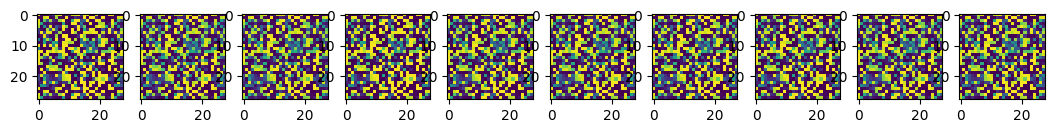

epochs done: 20


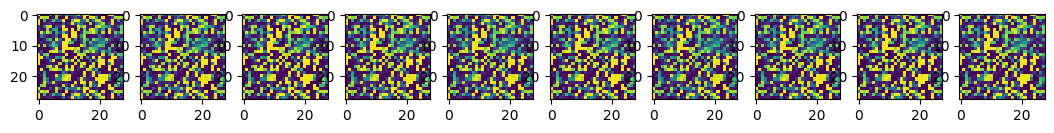

epochs done: 30


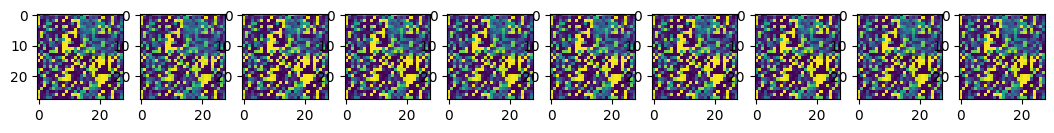

epochs done: 40


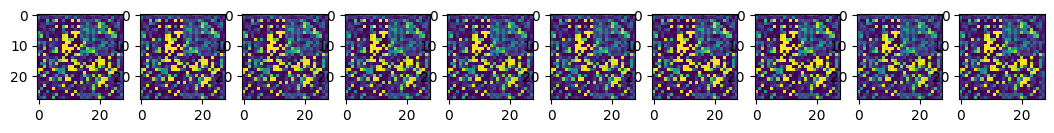

epochs done: 50


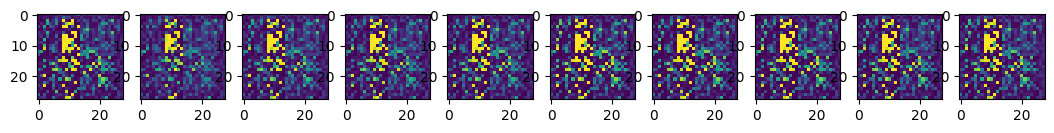

epochs done: 60


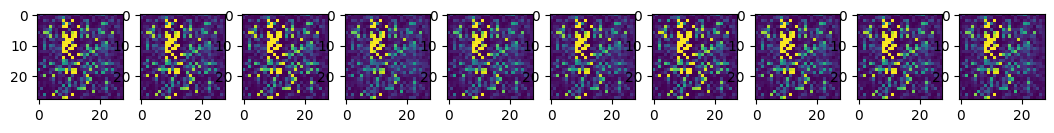

epochs done: 70


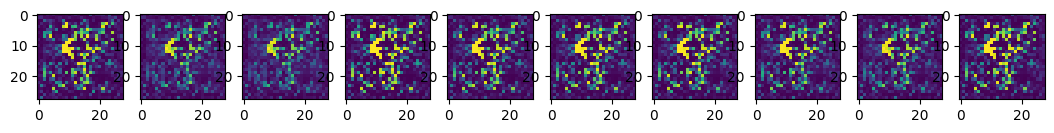

epochs done: 80


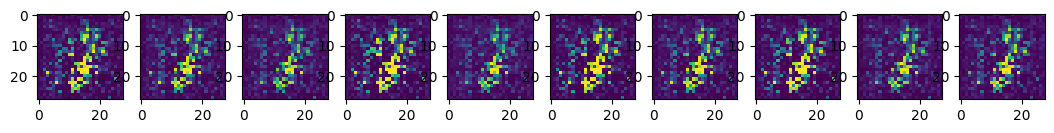

epochs done: 90


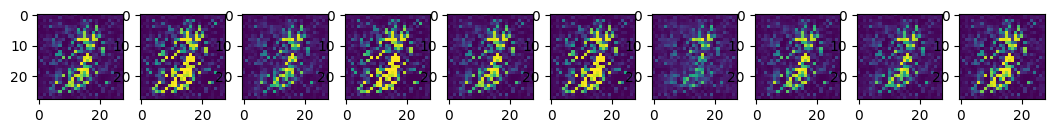

epochs done: 100


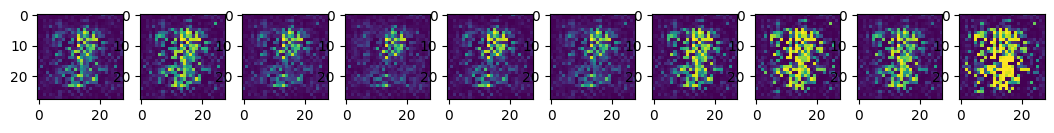

epoch_num,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/generator/wasserstein dist,▂▁▁▁▂▃▄▅▆▆▇▇▇▇█▇▆▅▅▅▅▅▅▅▆▆▅▅▅▄▃▃▃▃▃▃▄▄▄▄
epoch_num,99
train/generator/wasserstein dist,2.58623


KeyboardInterrupt: 

In [23]:
# y = torch.arange(10).to(get_local_device())
y = None
for epoch, gan in gan_trainer:
    if epoch % 10 == 0:
        print(f'epochs done: {epoch}')
        gen_several_images(gan, 10, y=y)

## Тестирую спектральную нормализацию

In [208]:
gan_trainer = form_gan_trainer(model_name='mnist_spectral_norm_test', n_epochs=4000)

epochs done: 10


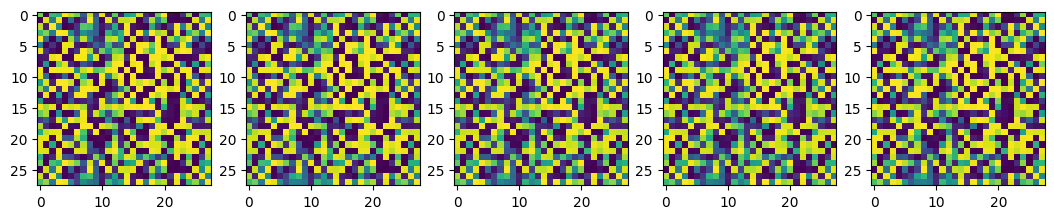

epochs done: 20


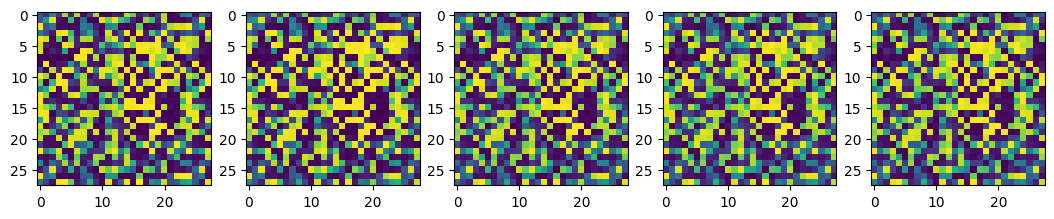

KeyboardInterrupt: 

In [209]:
for epoch, gan in gan_trainer:
    if epoch % 10 == 0:
        print(f'epochs done: {epoch}')
        gen_several_images(gan, 5)

## Физические данные

In [5]:
import contextlib
import os
from enum import Enum, auto
from typing import Tuple, Generator, Optional

import torch

import data
import logger
from discriminators import SimpleImageDiscriminator, MNISTDiscriminator, SimplePhysicsDiscriminator
from gan import GAN
from generators import SimpleImageGenerator, MNISTGenerator, SimplePhysicsGenerator
from wandb_logger import WandbCM
from normalization import apply_normalization, ClippingNormalizer, SpectralNormalizer
from storage import ExperimentsStorage
from train import Stepper, WganEpochTrainer, GanTrainer


def init_storage() -> ExperimentsStorage:
    # === config variables ===
    experiments_dir = './experiments'
    checkpoint_filename = './training_checkpoint'
    model_state_filename = './model_state'
    # ========================
    return ExperimentsStorage(experiments_dir=experiments_dir, checkpoint_filename=checkpoint_filename,
                              model_state_filename=model_state_filename)


experiments_storage = init_storage()


class Environment(Enum):
    LOCAL = auto()
    KAGGLE = auto()


ENV = Environment.LOCAL


def get_wandb_token() -> str:
    if ENV is Environment.LOCAL:
        return os.getenv('WANDB_TOKEN')
    elif ENV is Environment.KAGGLE:
        from kaggle_secrets import UserSecretsClient
        return UserSecretsClient().get_secret('WANDB_TOKEN')


def init_logger(model_name: str = ''):
    config = logger.get_default_config()
    @contextlib.contextmanager
    def logger_cm():
        try:
            with WandbCM(project_name='GANs', experiment_id=model_name, token=get_wandb_token(), config=config) as wandb_logger:
                yield wandb_logger
        finally:
            pass
    return logger_cm


def form_gan_trainer(model_name: str, gan_model: Optional[GAN] = None, n_epochs: int = 100) -> Generator[Tuple[int, GAN], None, GAN]:
    """
    :return: a generator that yields (epoch number, gan_model after this epoch)
    """
    logger_cm_fn = init_logger(model_name)
    # classes_cnt = 10
    dataset = data.get_physics_dataset('../caloGAN_case11_5D_120K.npz')

    noise_dimension = 50

    def uniform_noise_generator(n: int) -> torch.Tensor:
        return 2*torch.rand(size=(n, noise_dimension)) - 1  # [-1, 1]

    generator = SimplePhysicsGenerator(noise_dim=noise_dimension)
    discriminator = SimplePhysicsDiscriminator()
    discriminator = apply_normalization(discriminator, SpectralNormalizer)

    if gan_model is None:
        gan_model = GAN(generator, discriminator, uniform_noise_generator)

    generator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(generator.parameters(), lr=1e-3)
    )

    discriminator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(discriminator.parameters(), lr=1e-4)
    )

    epoch_trainer = WganEpochTrainer(n_critic=20, batch_size=64)

    model_dir = experiments_storage.get_model_dir(model_name)
    trainer = GanTrainer(model_dir=model_dir, use_saved_checkpoint=True, save_checkpoint_once_in_epoch=10000)
    train_gan_generator = trainer.train(dataset=dataset, gan_model=gan_model,
                                        generator_stepper=generator_stepper,
                                        critic_stepper=discriminator_stepper,
                                        epoch_trainer=epoch_trainer,
                                        n_epochs=n_epochs,
                                        logger_cm_fn=logger_cm_fn)
    return train_gan_generator



In [22]:
gan_trainer = form_gan_trainer(model_name='physics_data_test', n_epochs=100000)

batch,▁▃▅▆█▁▃▅█▁▃▅▆█▁▃▆█▁▃▅▆█▁▅▆█▁▃▅▆█▃▅▆█▁▃▅█
epoch,▁▂▃▄▅▅▆▇█
train/discriminator/loss,▁▄▇██▆▆▇▇▅▆▆▆▇▅▆▆▇▅▅▆▆▇▆▆▇▇▆▆▇▇▇▆▆▇▇▆▆▆▇
train/generator/loss,█▄▂▁▁▅▄▂▂
batch,5
epoch,9
train/discriminator/loss,-0.00381
train/generator/loss,-0.00156


In [14]:
data_train = np.load('../caloGAN_case11_5D_120K.npz')

In [15]:
def add_noise(arr):
    noise_coefs = 1 + np.random.normal(0, 0.1, size=arr.shape)
    return arr * noise_coefs

In [16]:
samples_indices = [0, 31516, 62946, 37323, 57956]

points = torch.Tensor(add_noise(
    data_train['ParticlePoint'][samples_indices, :2]
))
momentums = torch.Tensor(add_noise(
    data_train['ParticleMomentum'][samples_indices]
))

In [10]:
# new experiment
for epoch, gan in gan_trainer:
    if epoch % 10 == 0:
        print(f'epochs done: {epoch}')
        gen_several_images(gan, len(points), y=(points.to(get_local_device()), momentums.to(get_local_device())), figsize=(10, 7))

NameError: name 'gan_trainer' is not defined

## Baseline

In [22]:
import contextlib
import os
from enum import Enum, auto
from typing import Tuple, Generator, Optional, Dict, List

import numpy as np
import torch
import torch.utils.data

import data
import logger
from discriminators import SimplePhysicsDiscriminator, CaloganPhysicsDiscriminator
from evaluation import evaluate_model
from gan import GAN
from generators import SimplePhysicsGenerator, CaloganPhysicsGenerator
from metrics import *
from normalization import apply_normalization, SpectralNormalizer, ClippingNormalizer
from results_storage import ResultsStorage
from storage import ExperimentsStorage
from train import Stepper, WganEpochTrainer, GanTrainer
from wandb_logger import WandbCM


def init_storage() -> ExperimentsStorage:
    # === config variables ===
    experiments_dir = './experiments'
    checkpoint_filename = './training_checkpoint'
    model_state_filename = './model_state'
    # ========================
    return ExperimentsStorage(experiments_dir=experiments_dir, checkpoint_filename=checkpoint_filename,
                              model_state_filename=model_state_filename)


experiments_storage = init_storage()


def init_results_storage() -> ResultsStorage:
    # === config variables ===
    results_dir = './results'
    results_filename = './results.json'
    # ========================
    return ResultsStorage(storage_dir=results_dir, results_filename=results_filename)


results_storage = init_results_storage()


class Environment(Enum):
    LOCAL = auto()
    KAGGLE = auto()


ENV = Environment.LOCAL


def get_wandb_token() -> str:
    if ENV is Environment.LOCAL:
        return os.getenv('WANDB_TOKEN')
    elif ENV is Environment.KAGGLE:
        from kaggle_secrets import UserSecretsClient
        return UserSecretsClient().get_secret('WANDB_TOKEN')


def init_logger(model_name: str = '', project_name='GANs'):
    config = logger.get_default_config()
    @contextlib.contextmanager
    def logger_cm():
        try:
            with WandbCM(project_name=project_name, experiment_id=model_name, token=get_wandb_token(), config=config) as wandb_logger:
                yield wandb_logger
        finally:
            pass
    return logger_cm


def form_metric() -> Metric:
    return MetricsSequence(
        # CriticValuesDistributionMetric(values_cnt=1000),
        DataStatistics(
            # LongitudualClusterAsymmetryMetric(),
            # TransverseClusterAsymmetryMetric(),
            # ClusterLongitudualWidthMetric(),
            # ClusterTransverseWidthMetric(),
            # PhysicsPRDMetric(),
            # PhysicsPRDBinsMetric(),
            ConditionBinsMetric(dim_bins=torch.Tensor([3, 3]),
                                metric=AveragePRDAUCMetric,
                                condition_index=0),
        ),
    )


def form_result_metrics() -> Metric:
    return MetricsSequence(
#                PhysicsDataStatistics(
#                    KLDivergence(LongitudualClusterAsymmetryMetric()),
#                    KLDivergence(TransverseClusterAsymmetryMetric()),
#                    KLDivergence(ClusterLongitudualWidthMetric()),
#                    KLDivergence(ClusterTransverseWidthMetric()),
#                    AveragePRDAUCMetric(),
#                ),
           )


def form_dataset(train: bool = False) -> torch.utils.data.Dataset:
    data_filepath = '../caloGAN_case11_5D_120K.npz'
    return data.UnifiedDatasetWrapper(data.get_physics_dataset(data_filepath, train=train))


def form_gan_trainer(model_name: str, gan_model: Optional[GAN] = None, n_epochs: int = 100) -> Generator[Tuple[int, GAN], None, GAN]:
    """
    :return: a generator that yields (epoch number, gan_model after this epoch)
    """
    logger_cm_fn = init_logger(model_name)
    metric = form_metric()

    train_dataset = form_dataset(train=True)
    val_dataset = form_dataset(train=False)

    # for local testing
    val_size = int(0.1 * len(val_dataset))
    val_dataset = torch.utils.data.Subset(val_dataset, np.arange(val_size))
    # -------
    noise_dimension = 50

    def uniform_noise_generator(n: int) -> torch.Tensor:
        return 2*torch.rand(size=(n, noise_dimension)) - 1  # [-1, 1]

    generator = CaloganPhysicsGenerator(noise_dim=noise_dimension)
#     generator = apply_normalization(generator, SpectralNormalizer)
    discriminator = CaloganPhysicsDiscriminator()
#     discriminator = apply_normalization(discriminator, SpectralNormalizer)
    discriminator = apply_normalization(discriminator, ClippingNormalizer, clip_c=0.05)

    if gan_model is None:
        gan_model = GAN(generator, discriminator, uniform_noise_generator)

    generator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(generator.parameters(), lr=1e-3)
    )

    discriminator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(discriminator.parameters(), lr=1e-4)
    )

    epoch_trainer = WganEpochTrainer(n_critic=5, batch_size=100)

    model_dir = experiments_storage.get_model_dir(model_name)
    trainer = GanTrainer(model_dir=model_dir, use_saved_checkpoint=True, save_checkpoint_once_in_epoch=10)
    train_gan_generator = trainer.train(gan_model=gan_model,
                                        train_dataset=train_dataset, val_dataset=val_dataset,
                                        generator_stepper=generator_stepper,
                                        critic_stepper=discriminator_stepper,
                                        epoch_trainer=epoch_trainer,
                                        n_epochs=n_epochs,
                                        metric=metric,
                                        logger_cm_fn=logger_cm_fn)
    return train_gan_generator

In [23]:
gan_trainer = form_gan_trainer(model_name='physics_data_test_baseline', n_epochs=100000)

epochs done: 2


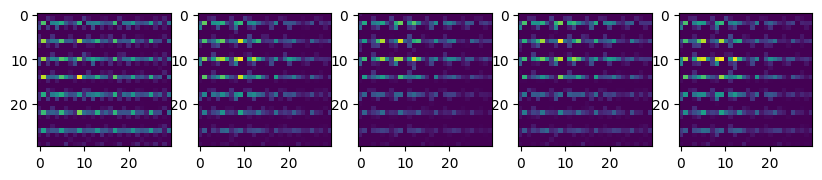

epochs done: 3


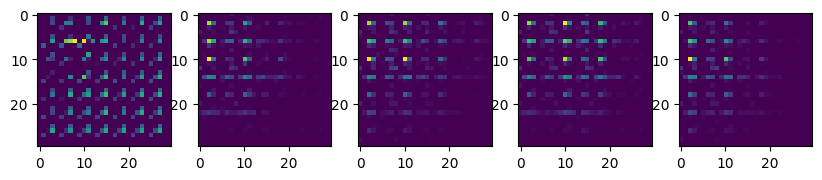

epochs done: 4


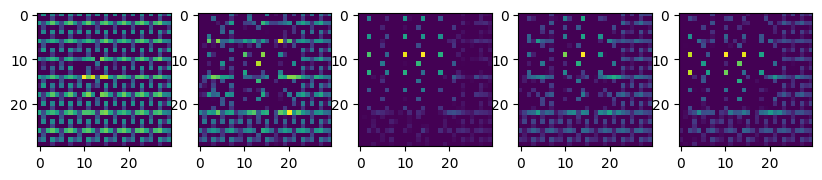

epochs done: 5


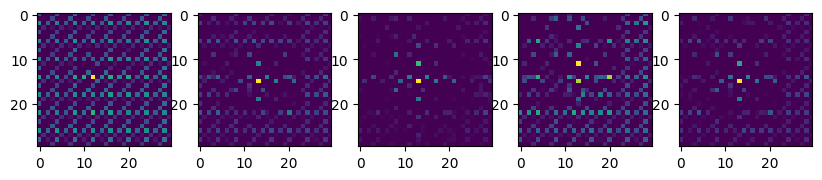

epochs done: 6


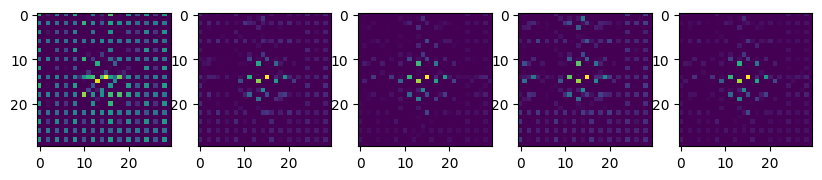

epochs done: 7


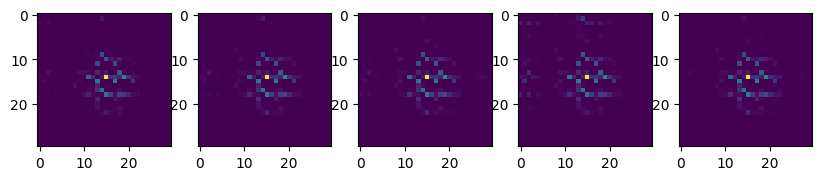

epochs done: 8


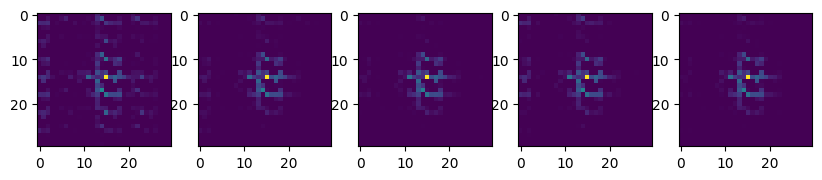

epochs done: 9


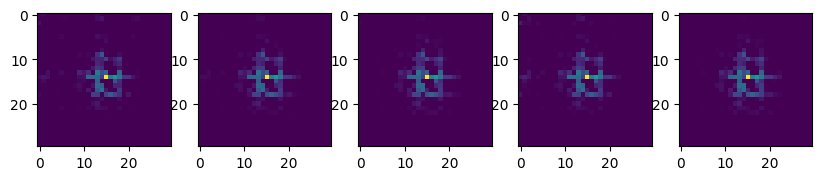

epochs done: 10


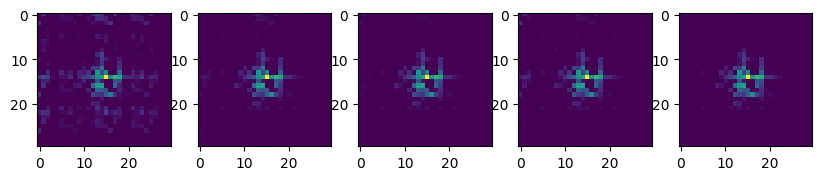

epochs done: 11


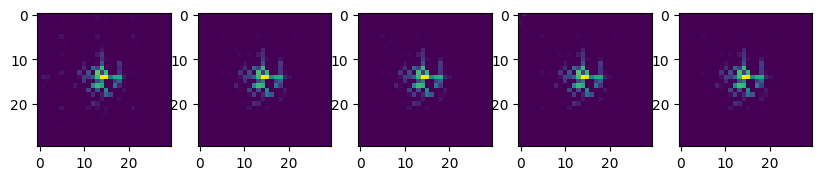

epochs done: 12


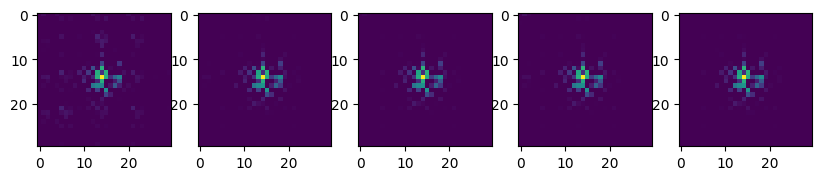

epochs done: 13


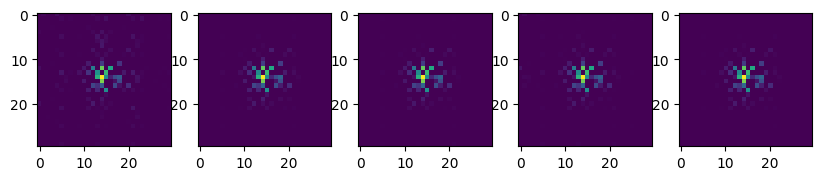

epochs done: 14


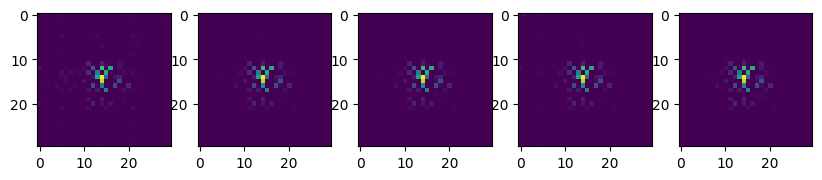

epochs done: 15


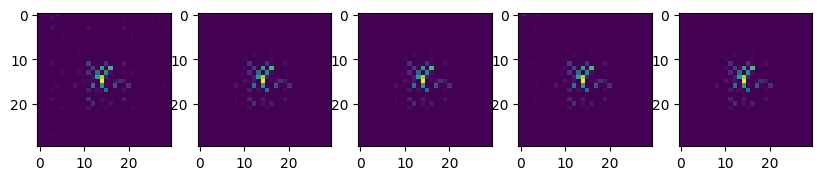

epochs done: 16


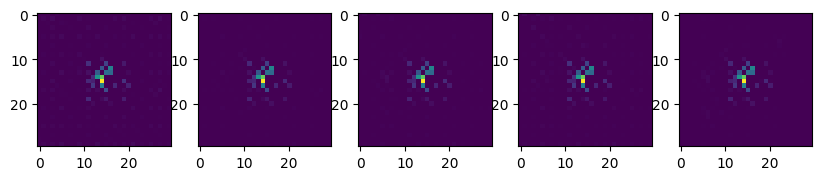

epochs done: 17


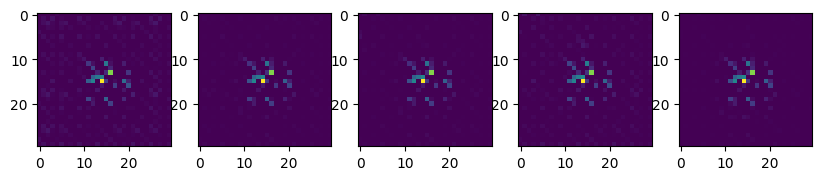

epochs done: 18


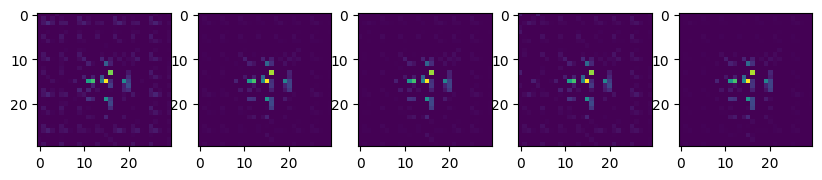

epochs done: 19


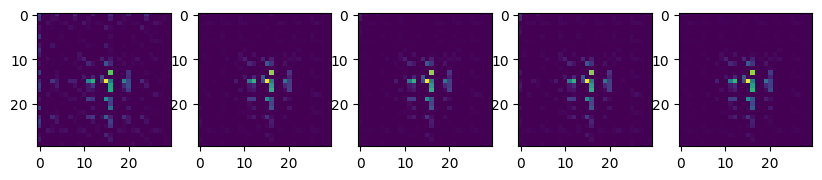

epochs done: 20


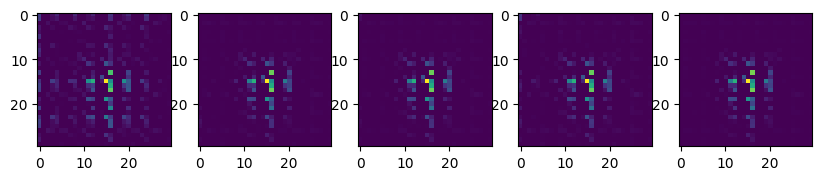

epochs done: 21


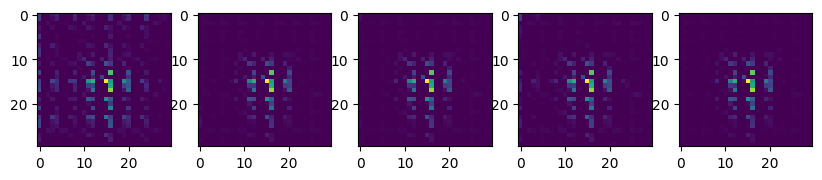

epochs done: 22


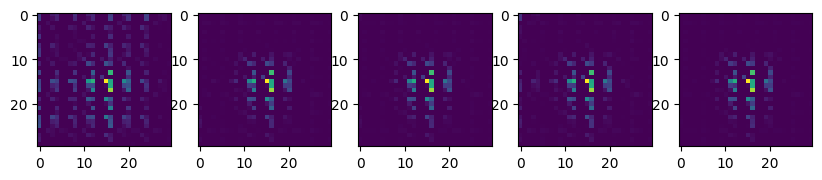

epochs done: 23


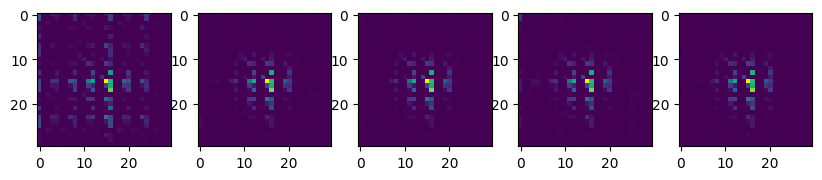

epochs done: 24


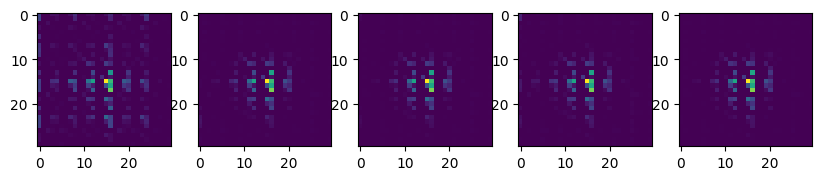

epochs done: 25


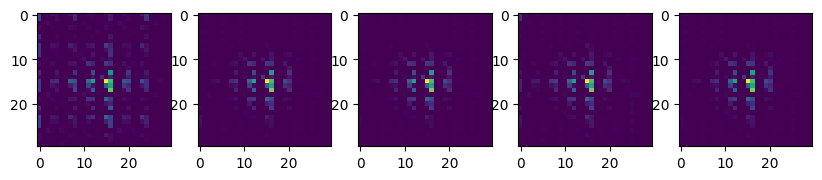

epochs done: 26


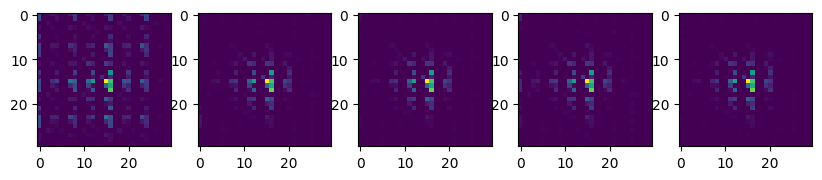

epochs done: 27


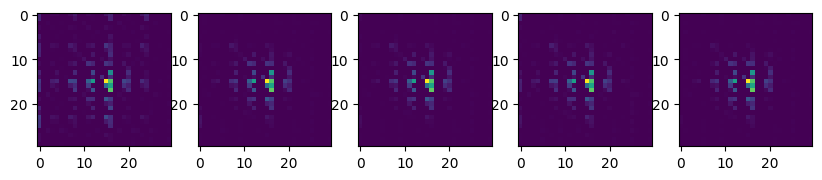

epochs done: 28


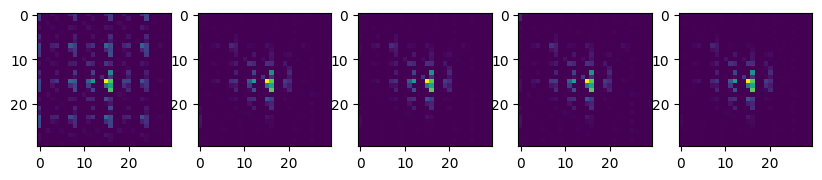

epochs done: 29


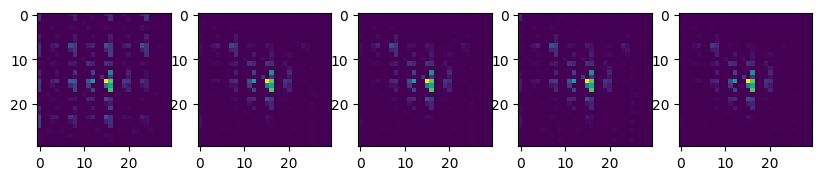

epochs done: 30


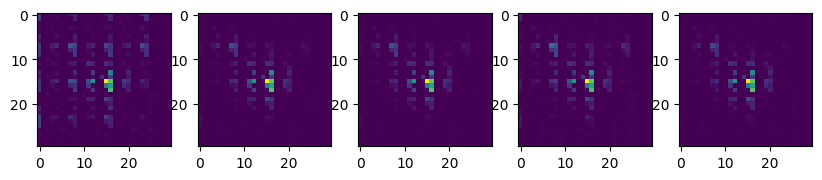

epochs done: 31


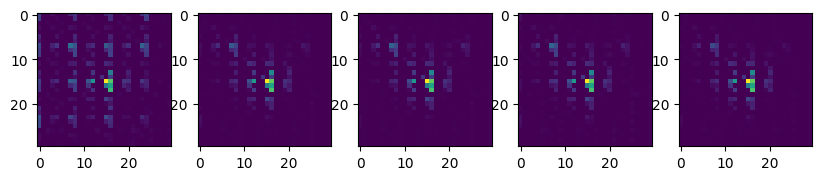

epochs done: 32


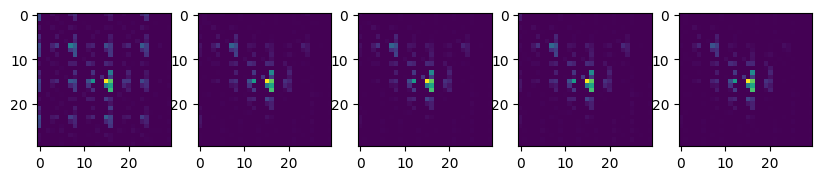

epochs done: 33


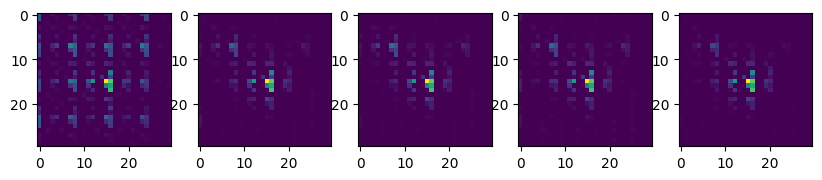

epochs done: 34


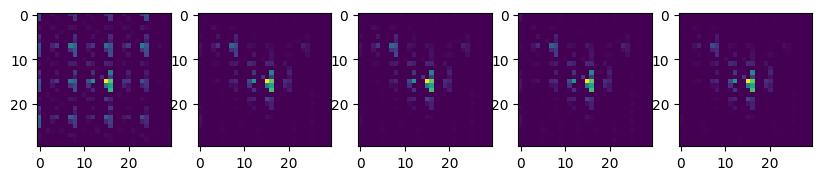

epochs done: 35


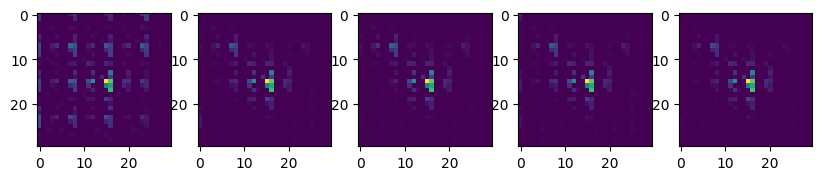

epochs done: 36


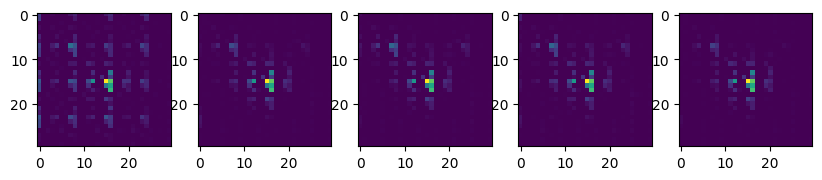

epochs done: 37


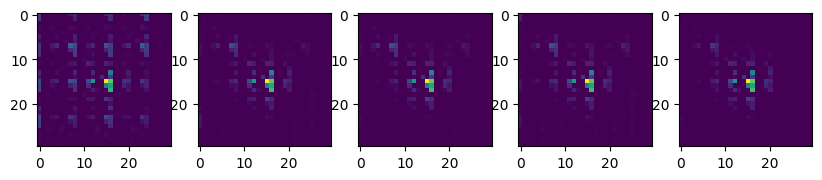

epochs done: 38


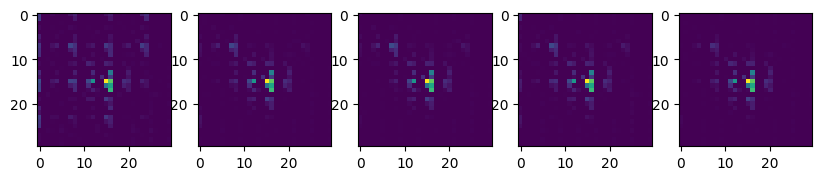

epochs done: 39


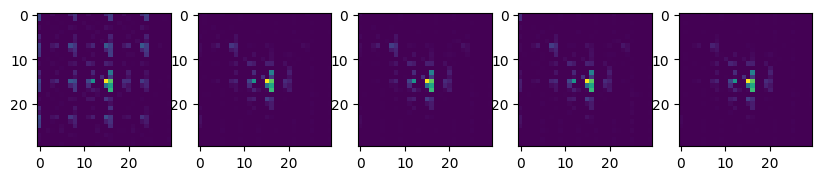

epochs done: 40


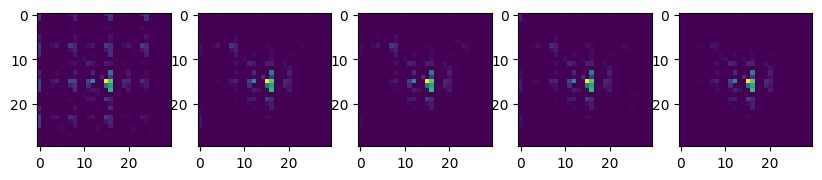

epochs done: 41


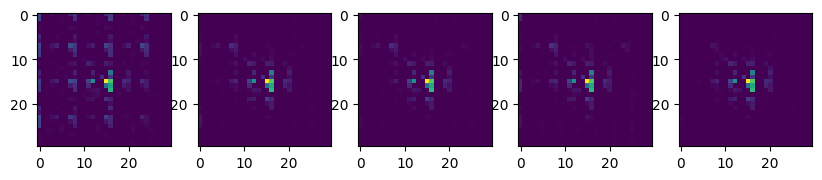

epochs done: 42


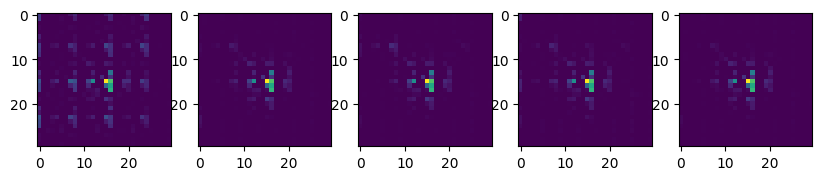

epochs done: 43


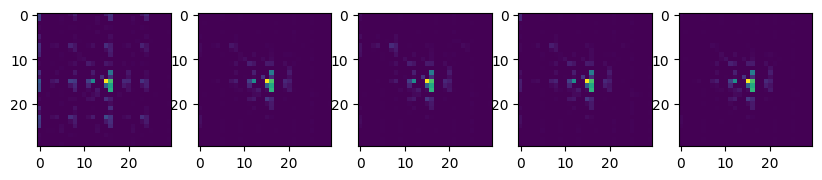

epochs done: 44


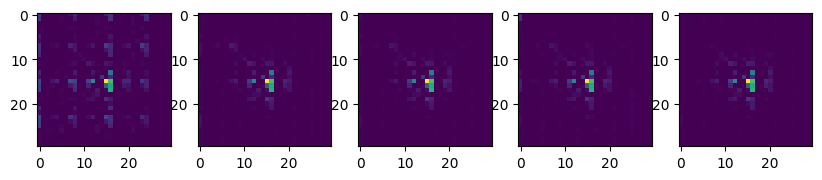

epochs done: 45


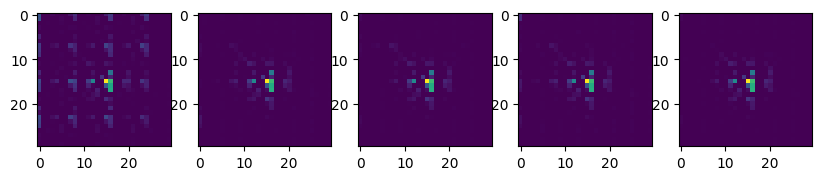

epochs done: 46


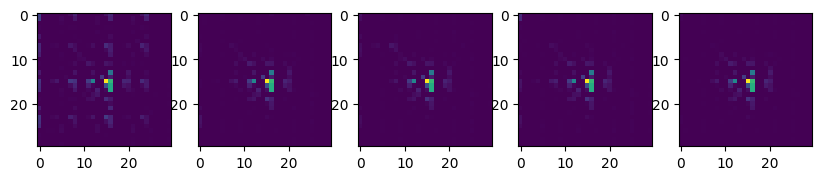

epochs done: 47


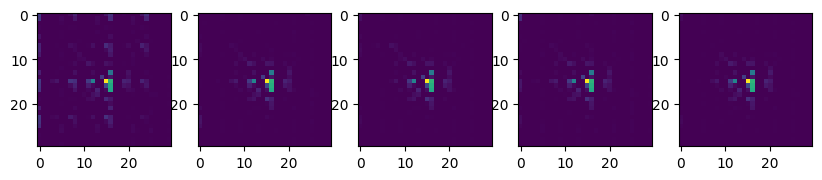

epochs done: 48


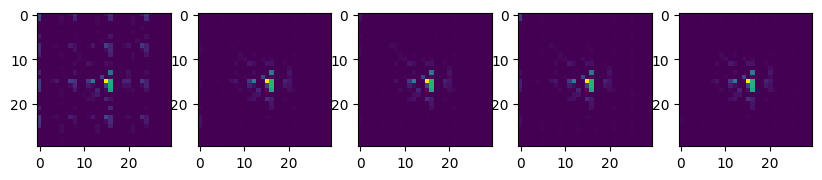

epochs done: 49


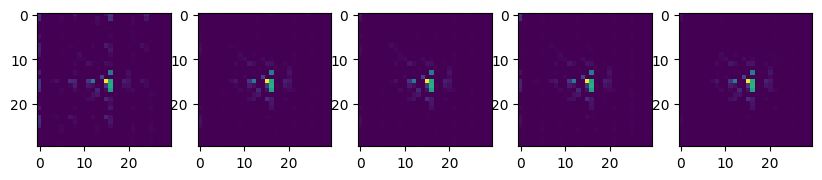

epochs done: 50


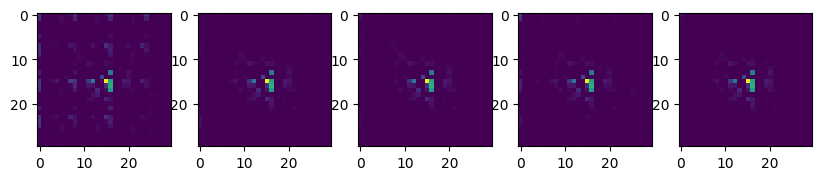

epochs done: 51


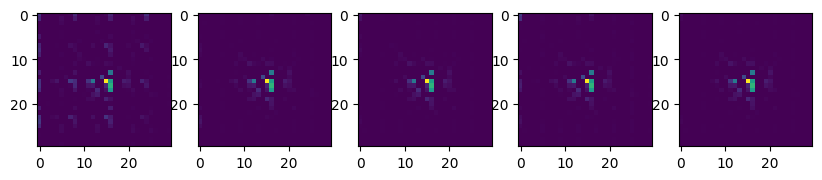

epochs done: 52


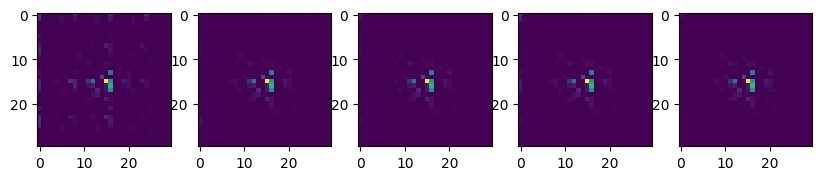

epochs done: 53


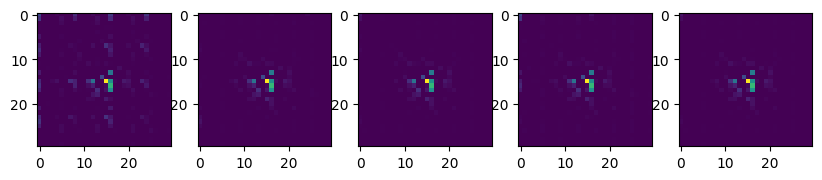

epochs done: 54


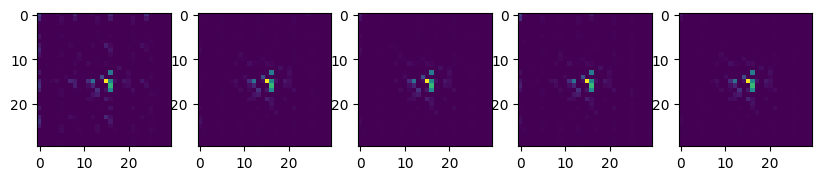

epochs done: 55


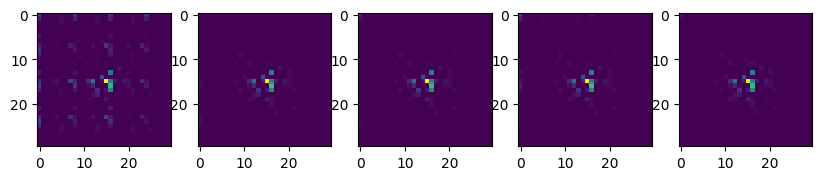

epochs done: 56


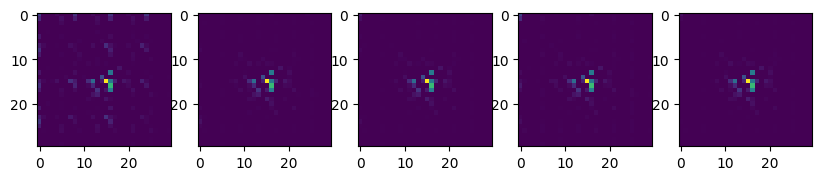

epochs done: 57


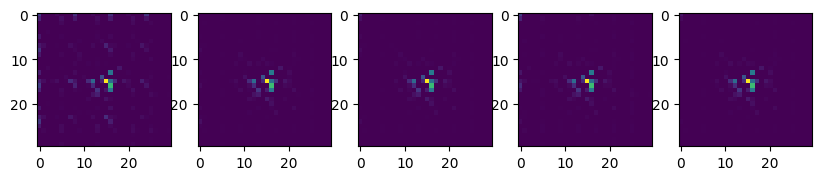

epochs done: 58


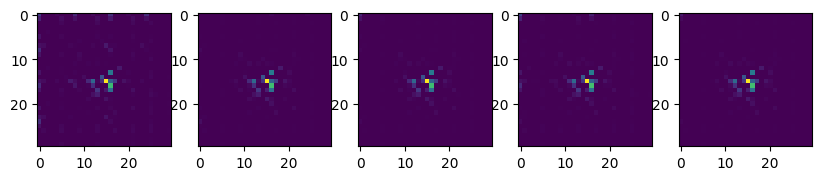

epochs done: 59


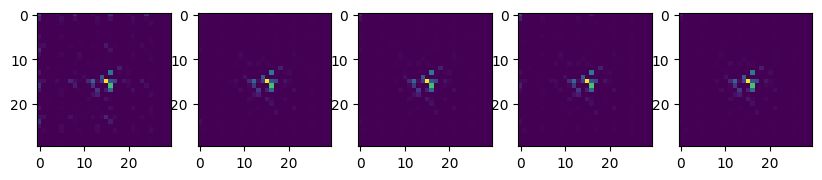

epochs done: 60


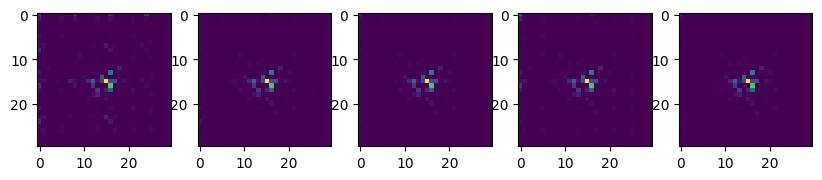

epochs done: 61


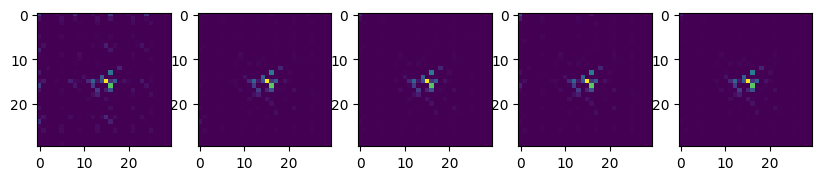

epochs done: 62


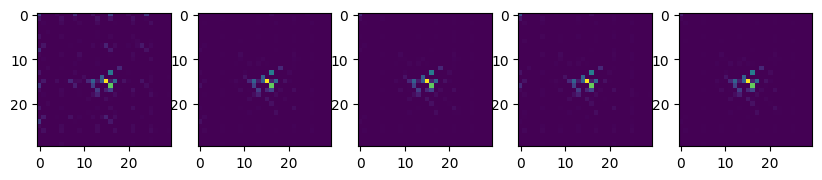

epochs done: 63


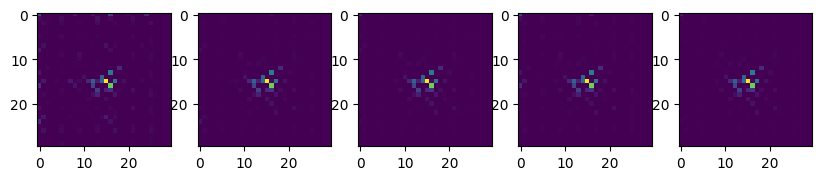

epochs done: 64


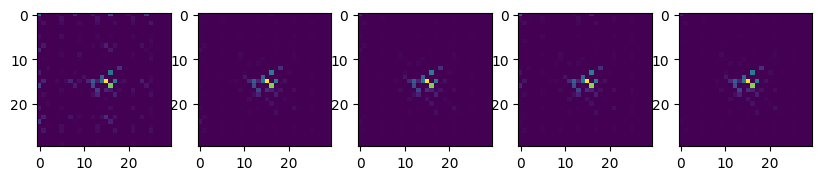

epochs done: 65


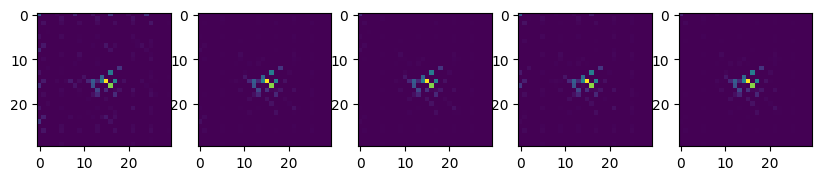

epochs done: 66


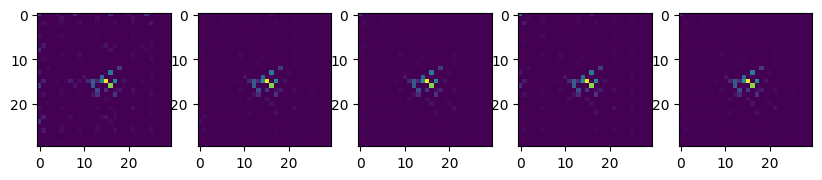

epochs done: 67


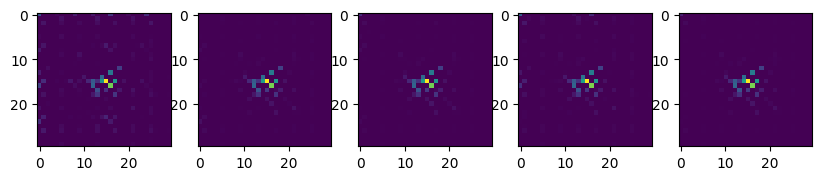

epochs done: 68


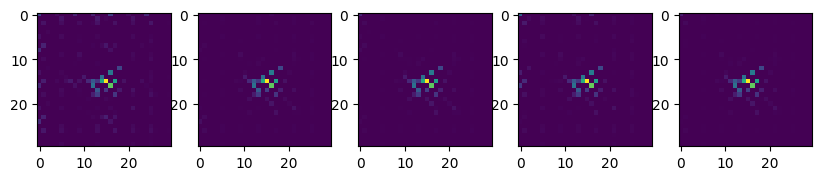

epochs done: 69


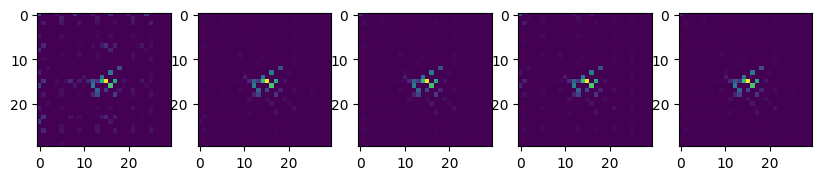

epochs done: 70


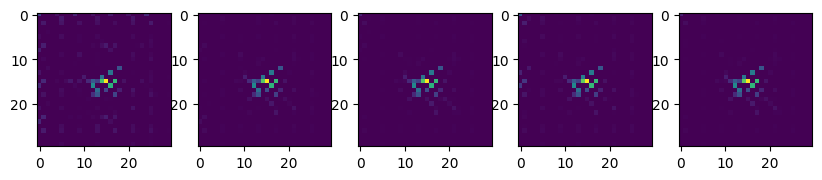

epochs done: 71


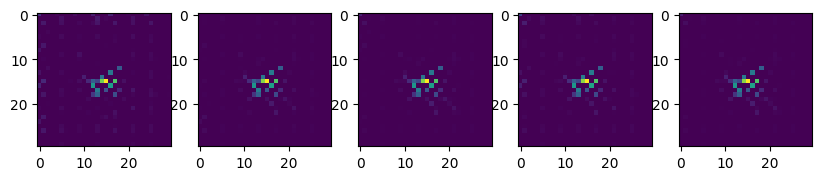

epochs done: 72


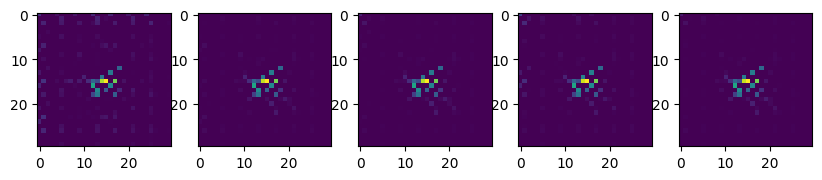

epochs done: 73


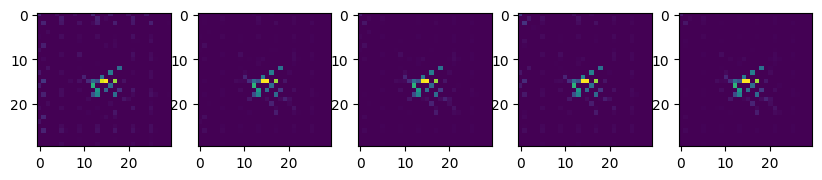

epochs done: 74


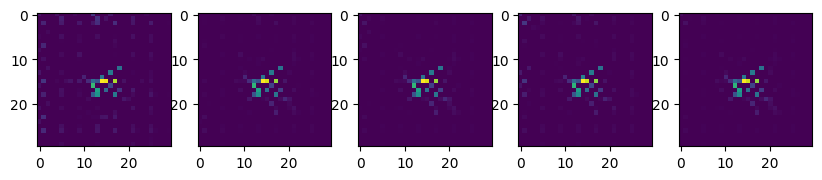

epochs done: 75


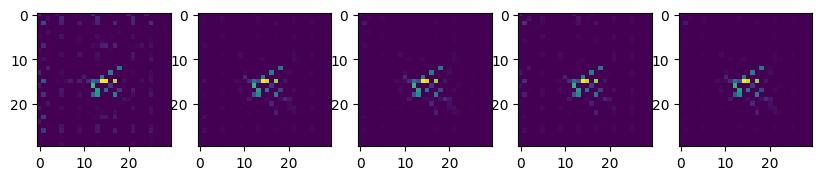

epochs done: 76


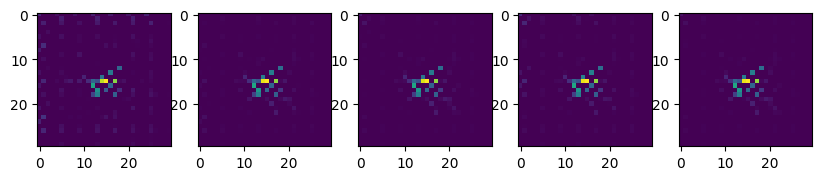

epochs done: 77


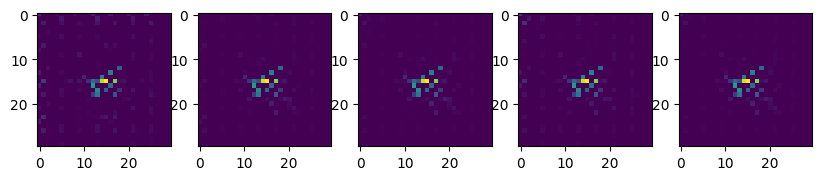

epochs done: 78


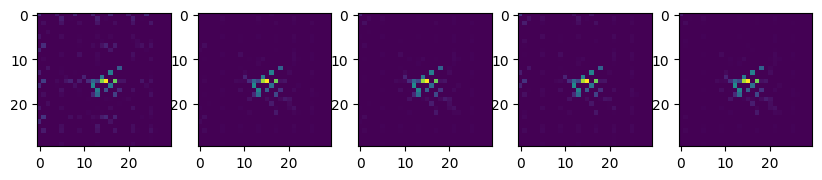

epochs done: 79


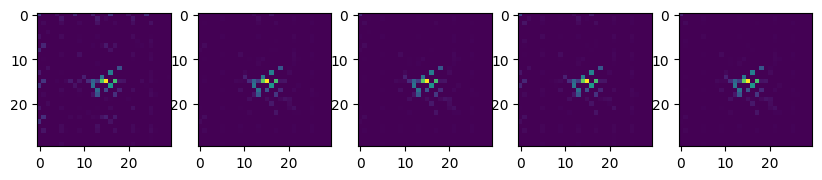

epochs done: 80


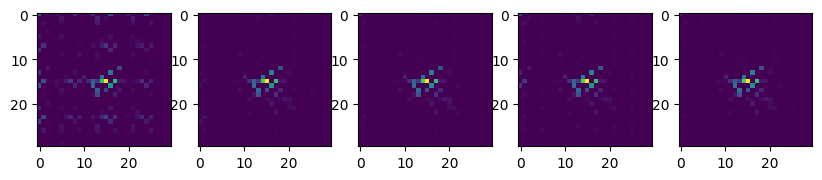

epochs done: 81


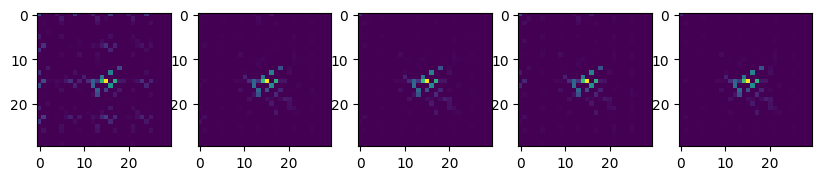

epochs done: 82


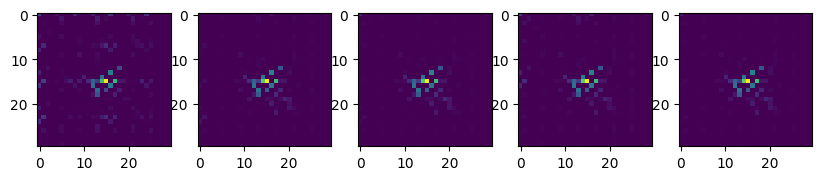

epochs done: 83


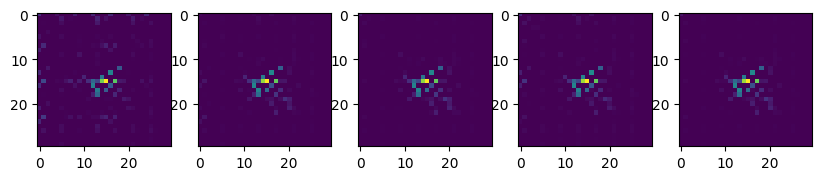

epochs done: 84


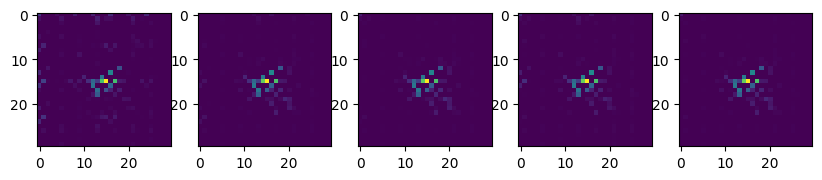

epochs done: 85


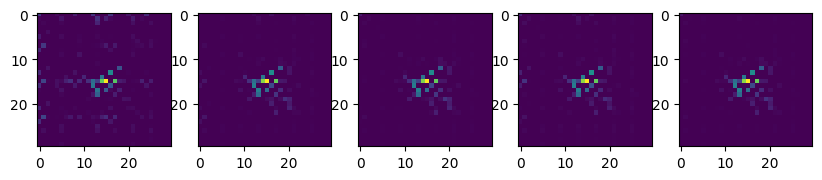

epochs done: 86


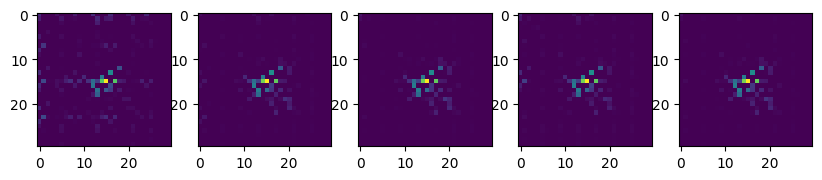

epochs done: 87


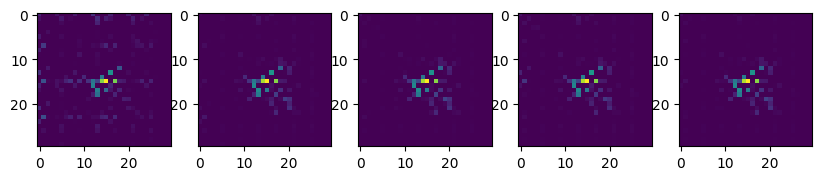

epochs done: 88


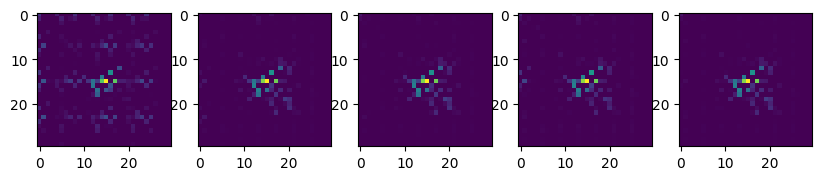

epochs done: 89


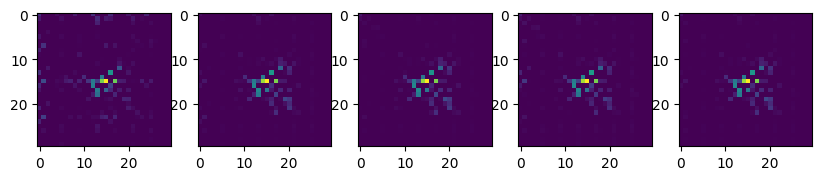

epochs done: 90


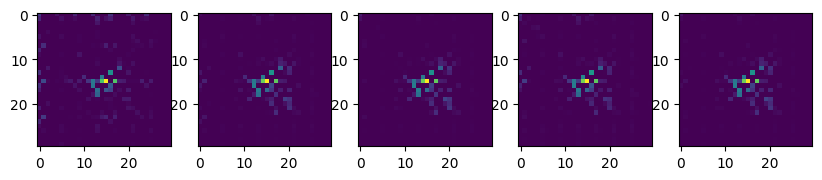

epochs done: 91


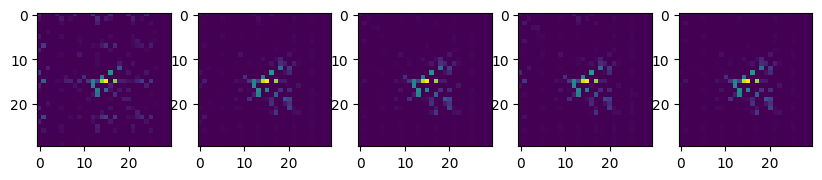

epochs done: 92


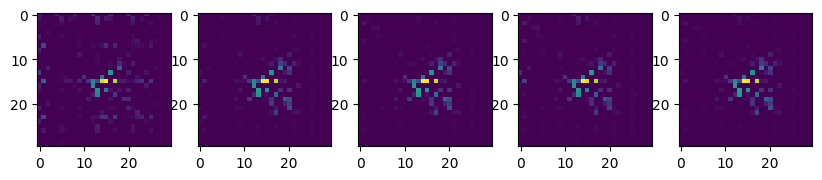

epochs done: 93


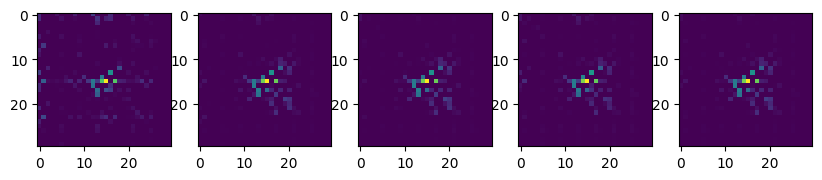

epochs done: 94


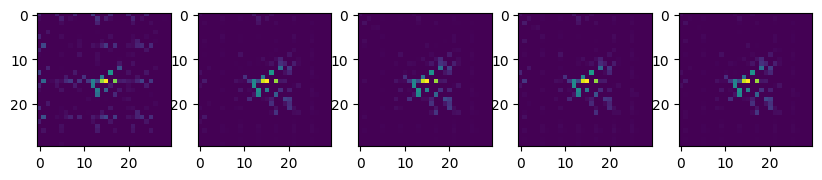

epochs done: 95


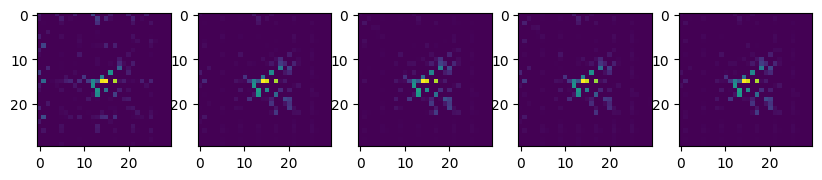

epochs done: 96


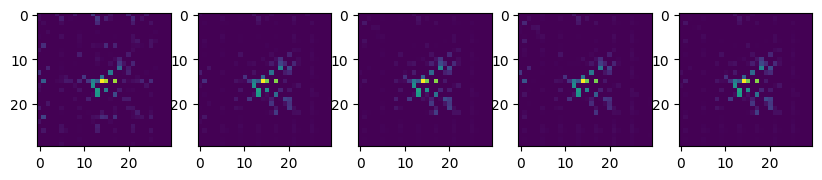

epochs done: 97


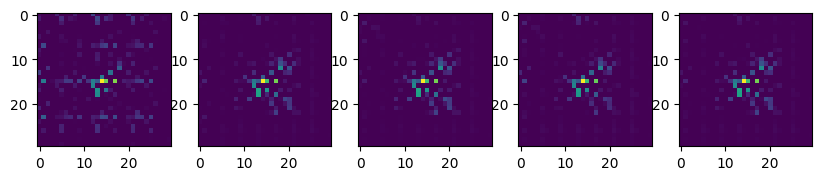

epochs done: 98


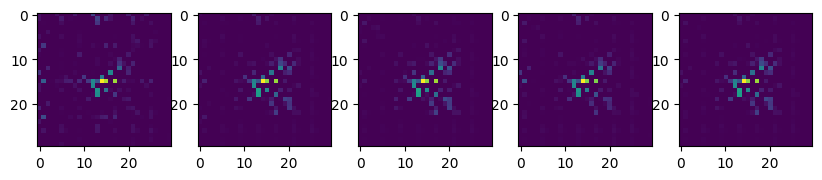

epochs done: 99


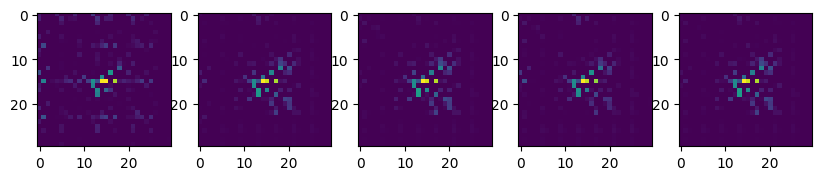

epochs done: 100


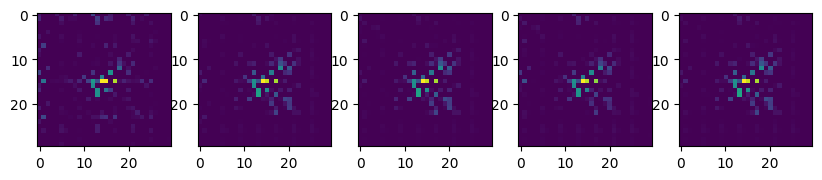

epochs done: 101


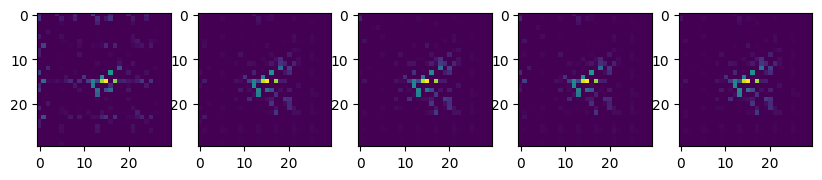

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/critic/loss,▆▆▄▅▅▃▁██▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
train/generator/loss,▃▃▄▄▅▆█▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,100
train/critic/loss,9e-05
train/generator/loss,0.00016


KeyboardInterrupt: 

In [21]:
# new experiment
for epoch, gan in gan_trainer:
    if epoch % 1 == 0:
        print(f'epochs done: {epoch}')
        gen_several_images(gan, len(points), y=(points.to(get_local_device()), momentums.to(get_local_device())), figsize=(10, 7))

## Визуализация распределения значений дискриминатора

In [34]:
dataset = data.get_physics_dataset('../caloGAN_case11_5D_120K.npz')

In [35]:
from metrics import CriticValuesDistributionMetric

In [89]:
metric = CriticValuesDistributionMetric(values_cnt=10000)

In [90]:
critic_vals_true, critic_vals_gen = metric(gan_model=gan, dataset=dataset)

In [60]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

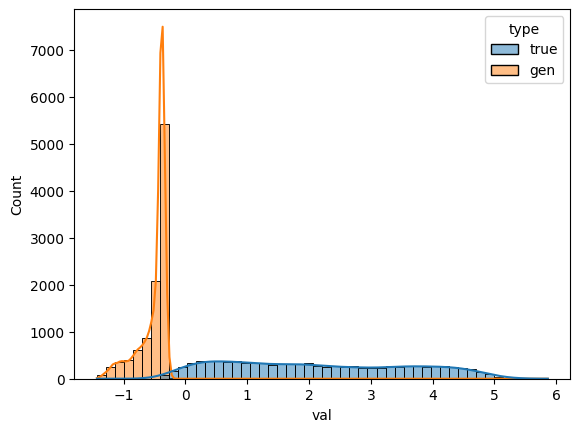

In [92]:
fig, ax = plt.subplots()

df = pd.DataFrame({
    'type': ['true'] * len(critic_vals_true) + ['gen'] * len(critic_vals_gen),
    'val': np.concatenate((critic_vals_true, critic_vals_gen))
})

# ax.hist(critic_vals_true, bins=10, label='true')
sns.histplot(data=df, x='val', hue='type', bins=50,  kde=True, ax=ax)
# ax.hist(critic_vals_gen, bins=10, label='gen')

# plt.legend()
plt.show()

In [9]:
import scipy
import numpy as np
from matplotlib import pyplot as plt

In [7]:
vals = np.linspace(0, 10, num=60000)

In [11]:
kernel = scipy.stats.gaussian_kde(vals)

In [94]:
kernel_true = scipy.stats.gaussian_kde(critic_vals_true)
kernel_gen = scipy.stats.gaussian_kde(critic_vals_gen)

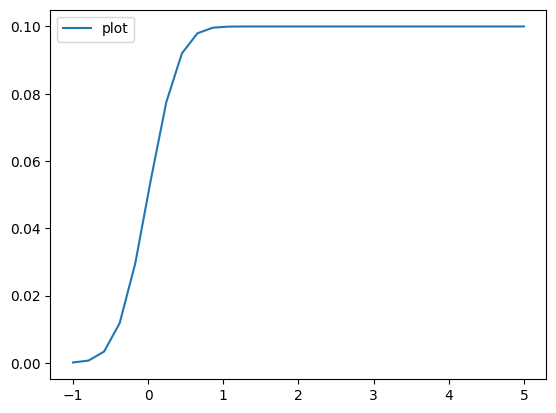

In [12]:
fig, ax = plt.subplots()

xs = np.linspace(-1, 5, num=30)

ax.plot(xs, kernel(xs), label='plot')
# ax.plot(xs, kernel_true(xs), label='true')
# ax.plot(xs, kernel_gen(xs), label='gen')

plt.legend()
plt.show()

In [98]:
type(xs)

numpy.ndarray

In [4]:
import numpy as np

In [6]:
x = np.array([5, 3, 4, 2, 1])

In [8]:
quantile_removed = 0.01

In [9]:
lower_bound = np.quantile(x, quantile_removed/2)
upper_bound = np.quantile(x, 1-quantile_removed/2)

In [10]:
x[(x > lower_bound) & (x < upper_bound)]

array([3, 4, 2])

# PRD

In [1]:
import wandb
import numpy as np

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trickman. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(
    project='GANs',
    name='test_histogram'
)

In [4]:
f1 = lambda x: x**2
f2 = lambda x: (x-1)**2

xs = np.random.uniform(low=-2, high=2, size=100)

In [5]:
ys1 = f1(xs)
ys2 = f2(xs)

In [6]:
data = []
for y in ys1:
    row = [y, 'f1']
    data.append(row)
for y in ys2:
    row = [y, 'f2']
    data.append(row)

table = wandb.Table(data=data, columns=['value', 'type'])
fields = {
    'groupKeys': 'type',
    'value': 'value',
    'title': 'my histogram',
}
composite_histogram = wandb.plot_table(vega_spec_name="trickman/my_histogram", data_table=table, fields=fields)
wandb.log({"my_custom_table_id" : composite_histogram})

In [7]:
wandb.finish()

In [8]:
true_vals = f1(xs)
gen_vals = f2(xs)

## KL-divergence

In [130]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [235]:
samples_cnt = 10000
true_vals = np.random.normal(loc=0., scale=2, size=samples_cnt)
gen_vals = np.random.normal(loc=3., scale=10, size=samples_cnt)

In [236]:
bins_cnt = 10
_, bins = pd.qcut(np.hstack(true_vals), q=bins_cnt, retbins=True)
bins[0] = true_vals.min() - 0.001
bins[-1] = true_vals.max() + 0.001

In [237]:
vals = np.hstack((true_vals))
true_bin_indices = np.searchsorted(bins, vals)
true_bin_indices[:5]  # индексы bin-ов

array([ 1,  9,  2,  6, 10])

In [238]:
np.unique(true_bin_indices, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [239]:
true_probs = np.unique(true_bin_indices, return_counts=True)[1] / len(vals)

In [240]:
def split_into_bins(bins, vals):
    """
    return densities of shape (len(bins) + 1,)
    """
    bin_indices = np.searchsorted(bins, vals)
    unique_vals, cnts = np.unique(bin_indices, return_counts=True)
    all_cnts = np.zeros(len(bins) + 1)
    all_cnts[unique_vals] = cnts
    
    return all_cnts / len(vals)

In [241]:
true_probs = split_into_bins(bins, true_vals)
gen_probs = split_into_bins(bins, gen_vals)

In [242]:
true_probs

array([0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0. ])

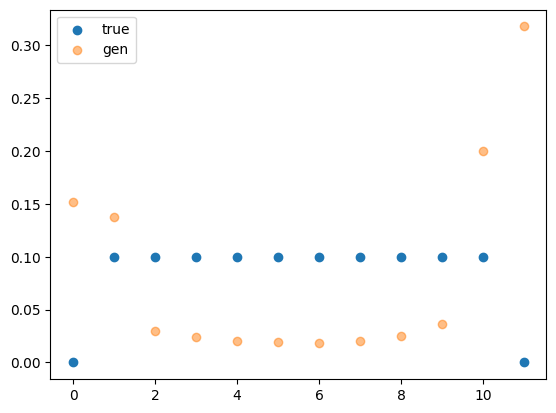

In [243]:
plt.scatter(np.arange(len(true_probs)), true_probs, label='true')
plt.scatter(np.arange(len(gen_probs)), gen_probs, label='gen', alpha=0.5)
plt.legend()
plt.show()

In [244]:
bins

array([-7.22583094, -2.56392708, -1.66094321, -1.01823202, -0.47585886,
        0.0158097 ,  0.50461194,  1.03708567,  1.67152513,  2.60777261,
        7.79921903])

In [245]:
import torch
from torch.nn.functional import kl_div

In [246]:
calc_indices = true_probs != 0
calc_indices

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False])

In [247]:
if (gen_probs[calc_indices] == 0.).any():
    print('inf')
else:
    x = (true_probs[calc_indices] * np.log(true_probs[calc_indices] / gen_probs[calc_indices])).mean()
    print(x)
#     print(kl_div(input=torch.Tensor(gen_probs), target=torch.Tensor(true_probs), reduction='none').mean())

0.10557229079414761


In [248]:
np.inf

inf

In [158]:
kl_div(input=torch.Tensor(gen_probs), target=torch.Tensor(true_probs), reduction='batchmean')

tensor(-0.2007)

In [159]:
true_probs * np.log(true_probs / gen_probs)

/var/folders/_v/zlf95xvd2qq_6w2lc0kdq30h0000gn/T/ipykernel_62401/2199509092.py:1: RuntimeWarning: divide by zero encountered in divide
  true_probs * np.log(true_probs / gen_probs)
/var/folders/_v/zlf95xvd2qq_6w2lc0kdq30h0000gn/T/ipykernel_62401/2199509092.py:1: RuntimeWarning: invalid value encountered in divide
  true_probs * np.log(true_probs / gen_probs)


array([        inf,         inf,         inf,         inf,         inf,
               inf,  0.35065579,  0.12378744, -0.09516579, -0.17191888,
       -0.04121097,         nan])

In [ ]:
from torch.nn.functional import kl_div


def kl_div(true_probs, fake_probs):
    """
    true_probs, fake_probs must be of the same size.
    They are assumed to be probabilities of some discrete random variables
    return KL(true || fake)
    """
    

In [ ]:
def kl_div_approx(true_samples, gen_samples, bins=100):
    """
    делим true_samples на bin-ы по квантилям и считаем, что влево и вправо на бесконечности уходят по ещё одному bin-у
    затем по дискретизированным согласно этим bin-ам величинам считаем дивергенцию
    """
    

## results

In [16]:
from results_storage import ResultsStorage

In [17]:
res_storage = ResultsStorage()

In [18]:
exp_info = res_storage.get_experiment_info('physics_data_test_baseline')

In [19]:
exp_info.get_result().metrics

{'Longitudual Cluster Asymmetry KL': inf,
 'Transverse Cluster Asymmetry KL': 8.515425891418194e-05}

In [20]:
exp_names = ['physics_data_test_baseline', 'physics_data_test_baseline2']

In [27]:
rows = []

for exp_name in exp_names:
    exp_info = res_storage.get_experiment_info(exp_name)
    data_row = exp_info.get_result().metrics
    data_row['name'] = exp_name
    
    rows.append(data_row)

In [28]:
import pandas as pd

In [30]:
pd.DataFrame(rows).set_index('name')

,Longitudual Cluster Asymmetry KL,Transverse Cluster Asymmetry KL
name,,
physics_data_test_baseline,inf,0.000085
physics_data_test_baseline2,0.4,0.300000


In [13]:
from main import form_gan_trainer

In [14]:
gan_trainer = form_gan_trainer(model_name='physics_data_test_baseline', n_epochs=1)

epochs done: 2


epoch,▁
train/generator/loss,▁
epoch,1
train/generator/loss,0.00903


[[inf, 8.515425891418194e-05]]


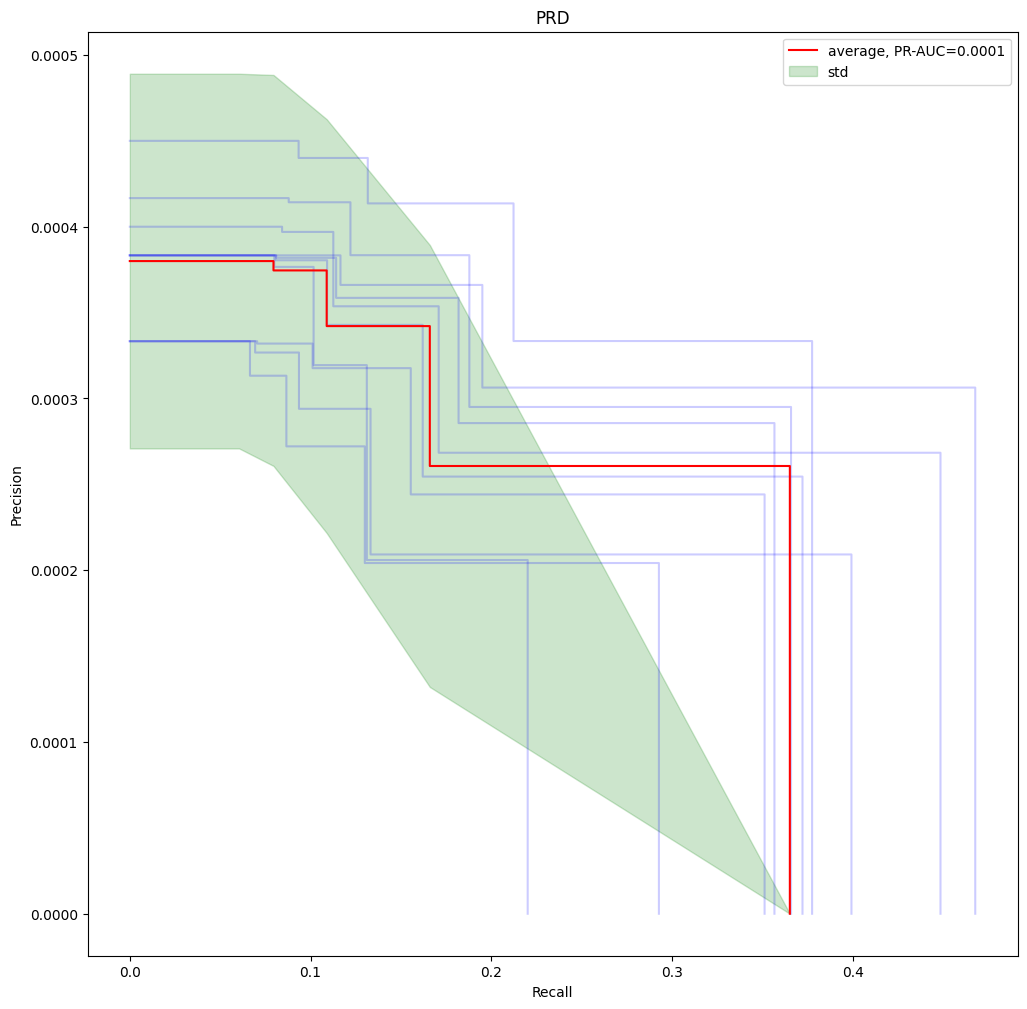

In [15]:
# new experiment
for epoch, gan in gan_trainer:
    if epoch % 1 == 0:
        print(f'epochs done: {epoch}')
#         gen_several_images(gan, len(points), y=(points.to(get_local_device()), momentums.to(get_local_device())), figsize=(10, 7))

In [45]:
a = np.array([
    1,
    2,
    3
])

In [46]:
b = np.array([
    [10, 100],
    [20, 200],
    [30, 300],
])

In [47]:
a[:, None].shape

(3, 1)

In [48]:
b.shape

(3, 2)

In [51]:
np.hstack((a[:, None], b))

array([[  1,  10, 100],
       [  2,  20, 200],
       [  3,  30, 300]])

In [38]:
import numpy as np

In [60]:
x = np.array([1, np.nan, np.inf])

In [61]:
np.isnan(x).any()

True

In [64]:
np.isinf(x).any()

True

In [66]:
~np.isnan(x)

array([ True, False,  True])

In [67]:
np.isnan(x).astype(bool)

array([False,  True, False])